## A/B Testing For Significance in Gate Appearances 

We want to test for statistical significance in the appearance of "Gates" at level 30 and 40 in the game. If there is a difference, we should highlight it and take needed action. 

First we'd like to explore the data is valid and cleaned

In [3]:
#import basic packages and check data
import pandas as pd
import numpy as np

data = pd.read_csv('gamedata.csv')
print(data.head())

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True


In [4]:
#review data is valid and cleaned
print(data.info())
print(data['retention_1'].value_counts())
print(data['retention_7'].value_counts())
print(data['userid'].duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None
retention_1
False    50036
True     40153
Name: count, dtype: int64
retention_7
False    73408
True     16781
Name: count, dtype: int64
0


Now that the data looks validated, we can look at general proportions of people who came back to play the game after 1 day in the 'retention_1' binary column for True/False in total and in between A/B segements

In [6]:
# percent of all players that came back after 1 day
print(data['retention_1'].mean())

# percent of all players that came back after 1 day between A/B groups
print(data.groupby('version')['retention_1'].mean())


0.4452095044850259
version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64


Looking at the averages, gate 30 seems to have a better retention but we cannot be sure this is statistically significant without testing since it is such a small difference.

Since data is categorical, we can look into a chi test beacuse normalcy and variance wouldn't play a big role. Similarly, a bootstrap approach looking into differences would also not require normalcy just a large enough sample. We can use both to verify our findings.

In [8]:
# Check that there are roughly the same amount of users in each group version (30/40)
print(data['version'].value_counts())

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64


## Performing statistical tests to validate (CHI Squared test for independence/bootstraps)

In [10]:
# import package
from scipy.stats import chi2_contingency

# Create a contingency table for the A/B test partitioning data (retention_1 vs version)
contingency_table = pd.crosstab(data['version'], data['retention_1'])

# Perform a chi-square test for independence
print(chi2_contingency(contingency_table))

# Compare retention rates for each version
print(data.groupby('version')['retention_1'].mean())



Chi2ContingencyResult(statistic=3.1591007878782262, pvalue=0.07550476210309086, dof=1, expected_freq=array([[24799.13514952, 19900.86485048],
       [25236.86485048, 20252.13514952]]))
version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64


With a pvalue over 5% we cannot reject the null at this level. There is no significant difference.

We can now verify our results using the bootstrap method. This method selects with replacement from the data to create new averages over a large list to approximate if there is a significant difference in retention rates

In [ ]:
# create parameters for bootstrapping
n_bootstraps = 10000
bootstrap_30 = []
bootstrap_40 = []
bootstrap_diffs = []

# split the data into 30/40 gates
gate_30_retention = data[data['version'] == 'gate_30']['retention_1']
gate_40_retention = data[data['version'] == 'gate_40']['retention_1']


# create a loop to do the bootstrapping samples and place into bootstrap_diffs list object
for x in range(n_bootstraps):
    # Resample with replacement and calculate mean retention for each version
    gate_30_sample = np.random.choice(gate_30_retention, size=len(gate_30_retention), replace=True).mean()
    gate_40_sample = np.random.choice(gate_40_retention, size=len(gate_40_retention), replace=True).mean()

    bootstrap_30.append(gate_30_sample)
    bootstrap_40.append(gate_40_sample)
    
    # Calculate the difference in retention rates
    bootstrap_diffs.append(gate_30_sample - gate_40_sample)



b3 = pd.DataFrame(bootstrap_30, columns =['gate_30'])
b4 = pd.DataFrame(bootstrap_40, columns =['gate_40'])
df = pd.concat([b3, b4], axis = 1)

df_diff = pd.DataFrame(bootstrap_diffs, columns = ['diff'])

# plot them on the same axis to see differences
df.plot(kind='kde')

# plot their differences
df_diff.plot(kind='kde')



In [30]:
# Calculating the probability that 1-day retention difference is greater than 0 at gate_30
prob = (df_diff['diff'] > 0).sum() / len(df_diff)
print(prob)

0.9602


Looking at the graphs and calculating the probability that the difference is grater than 0 shows a slight push towards gate_30 likely being more effective, however we should still look further and check the confidence interval

In [28]:
# Calculate the 95% confidence interval for the difference in retention rates
conf_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])
mean_diff = np.mean(bootstrap_diffs)

mean_diff, conf_interval

0.9602


(0.005869476764277107, array([-0.00061642,  0.01238425]))

Since 0 lies in our confidence interval, at this level we would reject that there is a difference again verifying our first chi-squared test. However, since most of the differences lie above 0, we can further look into 7-day retention since users are also more likely to actually reach gate_40 over a longer period of time and 1-day retention may not be the greatest indicator




## Statistical testing on retention_7

In [48]:
# Inspect 7 day retention distributions
print(data.groupby('version')['retention_7'].mean())

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64


Gate_30 looks to have a higher avereage retention but lets analyze it statistically to be sure

In [53]:
# Create a contingency table for the A/B test partitioning data (retention_7 vs version)
contingency_table = pd.crosstab(data['version'], data['retention_7'])

# Perform a chi-square test for independence
print(chi2_contingency(contingency_table))

Chi2ContingencyResult(statistic=9.959086799559167, pvalue=0.0016005742679058301, dof=1, expected_freq=array([[36382.90257127,  8317.09742873],
       [37025.09742873,  8463.90257127]]))


With a pvalue of .16% we feel more confident that at least for 7-day retention, we can reject the null that there is no difference between the placement of gates and that gate_30 is likely statistically better suited. Let's now boostrap to see if we arrive at similar results.

<Axes: ylabel='Density'>

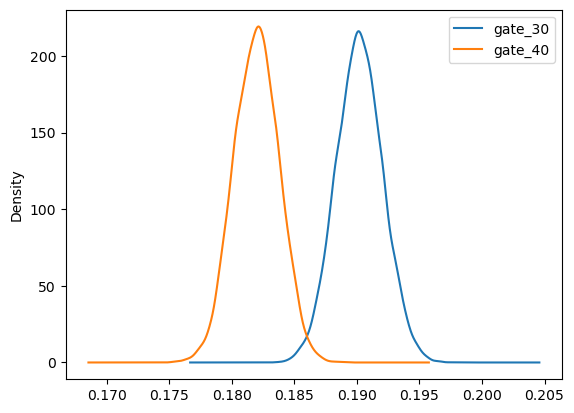

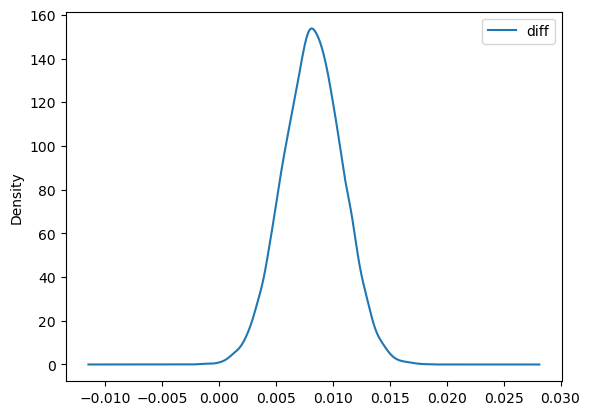

In [56]:
# create parameters for bootstrapping
n_bootstraps = 10000
bootstrap_30 = []
bootstrap_40 = []
bootstrap_diffs = []

# split the data into 30/40 gates
gate_30_retention = data[data['version'] == 'gate_30']['retention_7']
gate_40_retention = data[data['version'] == 'gate_40']['retention_7']


# create a loop to do the bootstrapping samples and place into bootstrap_diffs list object
for x in range(n_bootstraps):
    # Resample with replacement and calculate mean retention for each version
    gate_30_sample = np.random.choice(gate_30_retention, size=len(gate_30_retention), replace=True).mean()
    gate_40_sample = np.random.choice(gate_40_retention, size=len(gate_40_retention), replace=True).mean()

    bootstrap_30.append(gate_30_sample)
    bootstrap_40.append(gate_40_sample)
    
    # Calculate the difference in retention rates
    bootstrap_diffs.append(gate_30_sample - gate_40_sample)



b3 = pd.DataFrame(bootstrap_30, columns =['gate_30'])
b4 = pd.DataFrame(bootstrap_40, columns =['gate_40'])
df = pd.concat([b3, b4], axis = 1)

df_diff = pd.DataFrame(bootstrap_diffs, columns = ['diff'])

# plot them on the same axis to see differences
df.plot(kind='kde')

# plot their differences
df_diff.plot(kind='kde')



In [58]:
# Calculating the probability that 1-day retention difference is greater than 0 at gate_30
prob = (df_diff['diff'] > 0).sum() / len(df_diff)
print(prob)

# Calculate the 95% confidence interval for the difference in retention rates
conf_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])
mean_diff = np.mean(bootstrap_diffs)

mean_diff, conf_interval

0.9992


(0.008237282652299891, array([0.00317233, 0.01328373]))

Now, a difference of 0 is not in our confidence interval and the graph shows most of the data lies above.